In [172]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [173]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

In [562]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
tstamp = '1600397251'
#df = pd.read_sql("SELECT * FROM queries WHERE timestamp > 1600397251", con=connection)
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df = pd.concat([df,grav_df])

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.domain)

0        mobile.pipe.aria.microsoft.com
1        mobile.pipe.aria.microsoft.com
2                 telemetry.dropbox.com
3                        login.live.com
4                        edge.skype.com
                      ...              
83445          xn--localbitcins-vcd.com
83446                   siambiznews.com
83447                lp.searchmulty.com
83448                         usibw.top
83449          leanproconsulting.com.br
Name: domain, Length: 112930, dtype: object


In [392]:
def make_mask(x):
    y = np.zeros(100)
    y[:x] = 1
    return y

def make_multilabel(x):
    x_ = list(map(lambda xx: int(xx),x.split(' ')))
    y = np.zeros(100)
    y[range(len(x_))] = x_
    return y

In [628]:
#import sentencepiece as spm

# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
#spm.SentencePieceTrainer.train('--input=domains.txt --model_prefix=m --vocab_size=5000')

# makes segmenter instance and loads the model file (m.model)
#sp = spm.SentencePieceProcessor()
#sp.load('m.model')


import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "yttm_ads.model"

# Generating random file with training data
# 10000 lines with 100 characters in each line
#n_lines = 10000
#n_characters = 100
#with open(train_data_path, "w") as fout:
#    for _ in range(n_lines):
#        print("".join([random.choice("abcd ") for _ in range(n_characters)]), file=fout)

# Generating random text
test_text = "".join([random.choice("abcde ") for _ in range(10000)])

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=300, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[85], [222], [109], [4, 12], [204], [259], [], [86], [4, 12], [86], [259], [], [178], [249], [4, 12], [178], [], [85], [4, 12], [88], [249], [222], [76], [222], [137], [96], [], [88], [222], [85]]
[['▁m'], ['▁o'], ['▁b'], ['▁', 'i'], ['▁l'], ['▁e'], ['▁', '.'], ['▁p'], ['▁', 'i'], ['▁p'], ['▁e'], ['▁', '.'], ['▁a'], ['▁r'], ['▁', 'i'], ['▁a'], ['▁', '.'], ['▁m'], ['▁', 'i'], ['▁c'], ['▁r'], ['▁o'], ['▁s'], ['▁o'], ['▁f'], ['▁t'], ['▁', '.'], ['▁c'], ['▁o'], ['▁m']]
mobile pipe aria microsoft com


In [389]:
df_ = df.loc[df.client=='192.168.0.147'].reset_index()
df_['timestamp'] = df_.timestamp.round(-3)
df_dom = df_.groupby(['timestamp','domain']).count().reset_index()

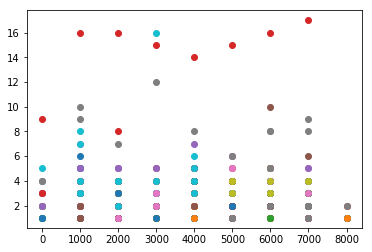

In [100]:
for dom in df_dom.domain.unique():
    df_dom_i = df_dom.loc[df_dom.domain==dom].reset_index()
    pl.plot(df_dom_i.timestamp.unique()-df_.timestamp.unique().min(),df_dom_i['index'],'o')

In [629]:
format_df = df.groupby('timestamp').sum().reset_index()
format_df['domain'] = df.groupby('timestamp')['domain'].apply(lambda x: '|'.join(x)).reset_index()['domain']
format_df['domain_list'] = df.groupby('timestamp')['domain'].apply(lambda x: ','.join(x)).reset_index()['domain']
format_df['mask_count'] = df.groupby('timestamp')['domain'].apply(lambda x: len(x)).reset_index()['domain']
format_df['domain'] = format_df['domain'].apply(lambda x: ' '.join(x.split('.')))
format_df['blocked_chain'] = df.groupby('timestamp')['blocked'].apply(lambda x: ' '.join([str(int(i)) for i in x])).reset_index()['blocked']

In [630]:
print(bpe.encode(list(format_df.domain.values[:4]), output_type=yttm.OutputType.SUBWORD))

[['▁m', 'obi', 'le', '▁p', 'ip', 'e', '▁', 'ari', 'a', '▁m', 'icro', 'sof', 't', '▁', 'com', '|', 'm', 'obi', 'le', '▁p', 'ip', 'e', '▁', 'ari', 'a', '▁m', 'icro', 'sof', 't', '▁', 'com'], ['▁t', 'ele', 'metr', 'y', '▁d', 'rop', 'bo', 'x', '▁', 'com'], ['▁', 'log', 'in', '▁', 'li', 've', '▁', 'com', '|', 'edg', 'e', '▁s', 'k', 'y', 'p', 'e', '▁', 'com', '|', 'oc', 'sp', '▁app', 'le', '▁', 'com', '|', 'con', 'f', 'ig', '▁', 'edg', 'e', '▁s', 'k', 'y', 'p', 'e', '▁', 'com', '|', 'pro', 'd', '▁re', 'g', 'i', 'st', 'r', 'ar', '▁s', 'k', 'y', 'p', 'e', '▁', 'com', '|', 'api', '▁', 'as', 'm', '▁s', 'k', 'y', 'p', 'e', '▁', 'com'], ['▁s', 's-', 'pro', 'd-', 'u', 'e1', '-', 'no', 'ti', 'f', '-', '5', '9', '▁a', 'w', 's', '▁ad', 'ob', 'es', 's', '▁', 'com']]


In [631]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.text import Tokenizer
#tokenize = Tokenizer()

encoded_docs = pad_sequences(list(bpe.encode(list(format_df.domain.values), output_type=yttm.OutputType.ID)),100,padding='post')#map(sp.encode_as_ids,format_df.domain.values)),100,padding='post')
masks = np.array(list(map(make_mask,format_df.mask_count)))
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

In [632]:
from tensorflow.keras.layers import Embedding,Dense,Input,Flatten,Concatenate,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam

In [643]:
def test_model():
    input_domains = Input(shape=(100,))
    input_mask = Input(shape=(100,))
    embed = Embedding(301,64)(input_domains)
    dense1 = Dropout(0.2)(Dense(64,activation='relu')(Flatten()(embed)))
    
    dense_mask = Dropout(0.2)(Dense(32,activation='relu')(input_mask))
    concat_dense = Concatenate()([dense1,dense_mask])
    dense_merge = Dense(100,activation='relu')(concat_dense)
    
    output = Dense(100,activation='sigmoid')(dense_merge)
    model = Model(inputs=[input_domains,input_mask],outputs=output)
    #SGD(learning_rate=1e-2)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [644]:
tm = test_model()

In [645]:
train,test = train_test_split(range(len(encoded_docs)))

In [646]:
tm.fit([encoded_docs[train],masks[train]],labels[train],validation_data=([encoded_docs[test],masks[test]],labels[test]),epochs=5)

Train on 10280 samples, validate on 3427 samples
Epoch 1/5
10280/10280 [==============================] - 5s 447us/sample - loss: 0.0415 - accuracy: 0.9828 - val_loss: 0.0096 - val_accuracy: 0.9972
Epoch 2/5
10280/10280 [==============================] - 3s 326us/sample - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0065 - val_accuracy: 0.9977
Epoch 3/5
10280/10280 [==============================] - 3s 327us/sample - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.0057 - val_accuracy: 0.9980
Epoch 4/5
10280/10280 [==============================] - 3s 329us/sample - loss: 0.0038 - accuracy: 0.9985 - val_loss: 0.0055 - val_accuracy: 0.9981
Epoch 5/5
10280/10280 [==============================] - 3s 333us/sample - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.0052 - val_accuracy: 0.9982


In [647]:
ref_model = tf.keras.models.clone_model(tm)
ref_model.set_weights(tm.get_weights())

In [648]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x):
        encoded_docs = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),100,padding='post').reshape(1,100)
        masks = np.array(make_mask(6)).reshape(1,100)
        return self.ml_model.predict([encoded_docs,masks])
        
mw = model_wrapper(ref_model,bpe)
mw.predict('abc.micro.com|lotsa.adserver.com|ads.microsoft.com|googleads.com|googleanalytics.server.org|ads.bbc.news.co.uk')

array([[7.22657144e-01, 9.94989216e-01, 9.46624994e-01, 3.05103660e-01,
        2.79167533e-01, 7.16407299e-02, 1.45350397e-02, 9.53406096e-04,
        9.24316049e-03, 2.65777111e-04, 1.32942200e-03, 1.63042545e-03,
        6.68406487e-04, 2.09447742e-03, 9.27954912e-04, 1.51479244e-03,
        2.60949135e-04, 4.44322824e-04, 4.40627337e-04, 3.21865082e-06,
        3.55243683e-05, 1.92523003e-04, 7.66217709e-05, 3.46899033e-05,
        1.41054392e-04, 1.80155039e-04, 5.53727150e-05, 9.81390476e-05,
        1.08420849e-04, 1.41859055e-05, 1.36435032e-04, 7.86602497e-04,
        7.39097595e-06, 7.86781311e-06, 1.36494637e-05, 1.04308128e-05,
        5.89191914e-05, 3.39746475e-06, 9.42945480e-05, 8.22544098e-06,
        7.15255737e-07, 4.67896461e-06, 3.49283218e-05, 5.45084476e-05,
        1.00135803e-05, 5.93364239e-05, 1.61528587e-05, 3.60608101e-06,
        1.87754631e-04, 1.69277191e-05, 1.08778477e-05, 8.01682472e-06,
        1.07884407e-05, 7.30156898e-06, 2.98023224e-06, 1.862645

In [71]:
masks = np.array(list(map(make_mask,format_df.mask_count)))

In [726]:
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

[0]
[0, 0, 0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[1, 0]
[1, 1]
[1]
[0, 0]
[0]
[1, 1, 0]
[1]
[0]
[1, 1]
[1]
[0]
[0]
[1, 1, 0, 0]
[0, 1]
[0, 0, 0]
[0]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0]
[1, 1]
[0]
[0, 1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 1, 0, 0]
[0, 1, 0]
[0]
[0, 0, 0, 0]
[1, 1]
[1]
[1, 1, 0]
[1]
[1, 1]
[1]
[0]
[1, 1]
[1]
[0]
[1, 1]
[1, 0]
[1]
[0]
[0]
[1, 1]
[0, 1]
[0, 1, 1, 1]
[0]
[0]
[1, 1]
[1]
[1, 1]
[1, 0]
[0]
[1, 1]
[1, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[1, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1, 0]
[1, 0]
[1, 1]
[0, 1]
[0, 0]
[1]
[0, 0, 0]
[0]
[1, 1]
[1]
[1]
[0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1, 0, 1, 0, 1]
[0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1, 1, 0, 0]
[0, 1]
[0]
[0, 0, 1, 1, 1]
[0]
[0]
[0]
[0]
[0]
[1, 1, 0]
[0, 1, 0]
[0, 1, 1]
[1]
[0]
[1, 1]
[0, 1]
[0]
[0, 0, 1, 0]
[1, 0, 0]
[0, 0, 0]
[0]
[1, 1]
[1, 0]
[1, 

[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[1, 1]
[1]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0, 0]
[0]
[0, 0]
[1]
[0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0, 0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 1, 0]
[0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0, 0, 1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1, 1]
[1, 1]
[0]
[0, 0, 0]
[1, 1]
[1]
[0]
[1, 1]
[0, 0]
[1]
[0]
[1, 1]
[0]
[1]
[0]
[0, 0]
[1, 1]

[1, 1, 0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[1, 0]
[0, 0]
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[1]
[0, 1]
[1, 0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[1]
[0, 0, 1, 0, 1, 1]
[1, 0, 1]
[0, 0, 0]
[0, 0]
[0]
[0]
[0, 1]
[1, 1]
[1, 0]
[0, 0]
[0]
[0]
[0]
[1, 1, 0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[0, 1]
[0, 1, 1]
[0, 1, 0]
[0]
[0, 1]
[0]
[0]
[1, 1, 1, 1]
[1]
[0, 0]
[0]
[0, 1, 1, 1, 1]
[0]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 0, 1]
[0]
[0, 1, 0]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1, 0]
[0]
[0]
[0]
[0, 0, 0]
[0, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[1]
[0, 0]
[0]
[0, 0

[0]
[0]
[0]
[0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0]
[0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 1, 1]
[1]
[0, 0]
[0]
[1]
[1, 1]
[0]
[1]
[0]
[1, 1]
[1]
[1]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[0]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[1]
[1]
[1]
[1, 1]
[1]
[0]
[0]
[1]
[0, 1]
[1]
[0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1, 0]
[1, 1, 1, 1, 1]
[0]
[0]
[1]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0, 1]
[1]
[0]
[1]
[1]
[1]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0]
[1]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0, 0]
[0, 0]
[1, 1, 

[0]
[1]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0, 0]
[0, 0, 0]
[0]
[1, 0]
[1, 0]
[0]
[0]
[0]
[0]
[1, 1, 1]
[0]
[0]
[1]
[0, 0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0, 0]
[1, 0]
[0]
[1, 1]
[0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1]
[1]
[1, 1, 0, 0, 1, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[1, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0]
[0, 0]
[1]
[0, 0, 0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1, 1]
[0]
[1]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[1, 0, 0]
[1, 1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0]
[0]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[0]
[0, 1]
[1]
[0]
[0]
[0]
[0]
[1, 1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0]
[1]
[1, 1]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1]
[0, 0]
[0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 1, 0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0, 0]
[0, 0]
[0]
[1]
[1]
[0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[1]
[1, 0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]


In [649]:
predicted = np.where(tm.predict([encoded_docs[test],masks[test]])>0.5,1,0).astype(bool)
domain_lists = list(map(lambda x: x.split(','),format_df.domain_list.loc[test].values))
bad_domains = list(map(lambda x: np.array(x[0])[x[1][:len(x[0])]],zip(domain_lists,predicted)))

In [650]:
bad_domains = [i[0] for i in bad_domains if len(i)>0]

In [651]:
parsed_domain_data = df.loc[df.blocked==1].domain.unique()

In [652]:
print(len(bad_domains))
[i for i in bad_domains if i not in parsed_domain_data]

1050


['c.aaxads.com',
 'gstaticadssl.l.google.com',
 'maven.io',
 'metrics.icloud.com',
 'mc.us3.list-manage.com',
 'l3.aaxads.com',
 'i.imgur.com',
 'ocsp-lb.apple.com.akadns.net',
 'l3.aaxads.com',
 'd.dropbox.com',
 'combo.staticflickr.com',
 'preview.redd.it',
 'geo.rlcdn.com',
 'd3e54v103j8qbb.cloudfront.net',
 'js.maxmind.com',
 'video.api.playstation.com',
 'gtq.sct.sc-prod.net',
 'external-preview.redd.it',
 'l3.aaxads.com',
 'cdn-ffc.oobesaas.adobe.com',
 'l.ssl.fastly.net',
 'youtube-ui.l.google.com',
 'www.redditstatic.com',
 'img3.hulu.com',
 'p.typekit.net',
 'i.stack.imgur.com',
 'lnkd.demdex.net',
 'dcape-na.amazon.com',
 'api.amazon.com',
 'jtvnw.twitchcdn.net',
 'video-weaver.dfw02.hls.ttvnw.net',
 'www.reddit.com',
 'www.gravatar.com',
 'duckduckgo.com',
 '119.0.168.192.in-addr.arpa',
 'api.amazon.com',
 'fonts.googleapis.com',
 'www.aaxdetect.com',
 'signal-metrics-collector-beta.s-onetag.com',
 'www.redditmedia.com',
 'alb.reddit.com',
 'out.reddit.com',
 'a.thumbs.reddi

In [60]:
tf.keras.models.save_model(tm,'./dns_anhilator.h5')

In [524]:
tm.optimizer.lr.assign(1e-4)
for i in range(800,900):
    if i == 0:
        labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],labels_forward,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
        ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
    else:
        tm_probs = tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        ref_probs = ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        tm_entropy = -np.sum(tm_probs*np.log(tm_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        ref_entropy = -np.sum(ref_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        labels_forward = np.where(tm_probs>0.5,1,0)
        ref_labels = np.where(ref_probs>0.5,1,0)
        print('Entropy TM',tm_entropy)
        print('Entropy Ref',ref_entropy)
        print('Cross Entropy:',-np.sum(tm_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1]))))
        if tm_entropy > ref_entropy:
            candidate_labels = np.where(tm_probs>np.random.normal(0.5,scale=0.05),1,0)#labels_forward.copy()
        else:
            candidate_labels = np.where(ref_probs>np.random.normal(0.5,scale=0.05),1,0)
        print(np.array(format_df.loc[test].iloc[i].domain_list))#[candidate_labels.astype(bool).reshape(-1)])
        print(ref_labels[0][:10])
        print(candidate_labels[0][:10])
        #candidate_labels = np.where(labels_forward != ref_labels, labels_forward, ref_labels)
        print('Models diverge:',not (np.sum(ref_labels)==np.sum(candidate_labels)))
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],candidate_labels,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
    print(np.sum(labels_forward==ref_labels)/ref_labels.size)
    

Entropy TM 0.00897728399192042
Entropy Ref 0.01715979587711284
Cross Entropy: 0.008429918202605777
ss-prod-ue1-notif-59.aws.adobess.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 108ms/sample - loss: 2.7380e-06 - accuracy: 1.0000 - val_loss: 1.0010e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.007908229439144654
Entropy Ref 0.015993621879262322
Cross Entropy: 0.0074515905674315645
swcdn.g.aaplimg.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 1.9415e-04 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9900
1.0
Entropy TM 0.6010989765541872
Entropy Ref 0.9368882426361604
Cross Entropy: 0.4207027936752464
www.google.com,telemetry.dropbox.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 

1/1 [==============================] - 0s 130ms/sample - loss: 2.0024e-06 - accuracy: 1.0000 - val_loss: 3.9160e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0035190563597074257
Entropy Ref 0.012326761629717636
Cross Entropy: 0.0031006413113071805
old.reddit.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 1.9393e-07 - accuracy: 1.0000 - val_loss: 5.8165e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.004931779151933813
Entropy Ref 0.015994706012640043
Cross Entropy: 0.004343793446327911
swcdn.g.aaplimg.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 5.4774e-06 - accuracy: 1.0000 - val_loss: 1.6464e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.012288048191362496
Entropy Ref 0.04166779743066424
Cross Entropy: 0.010546803184036396
edge178.stream.h

1/1 [==============================] - 0s 114ms/sample - loss: 4.2154e-07 - accuracy: 1.0000 - val_loss: 1.1477e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.06232553047700693
Entropy Ref 0.11693403988681908
Cross Entropy: 0.056323365655815576
smooth.pro17.akm.cdn.hbomax.com,smooth.pro17.akm.cdn.hbomax.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 1.0656e-05 - accuracy: 1.0000 - val_loss: 8.8259e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.00710614934262037
Entropy Ref 0.020506162145552894
Cross Entropy: 0.006313863743599371
lt501.tritondigital.com,lt501.tritondigital.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 5.4235e-05 - accuracy: 1.0000 - val_loss: 3.5572e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0032027795169779416
Entropy Ref

1/1 [==============================] - 0s 122ms/sample - loss: 1.9821e-06 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9200
1.0
Entropy TM 6.51764290819674
Entropy Ref 8.281618311637574
Cross Entropy: 5.90775147990422
connect.facebook.net,connect.facebook.net,scontent.xx.fbcdn.net,onetag-geo-grouping.s-onetag.com,onetag-geo-grouping.s-onetag.com,geo-location.s-onetag.com,geo-location.s-onetag.com,securepubads.g.doubleclick.net,securepubads.g.doubleclick.net,www.facebook.com,www.facebook.com,star-mini.c10r.facebook.com,segment-data-us-east.zqtk.net,segment-data-us-east.zqtk.net,fave.api.cnn.io,fave.api.cnn.io
[0 0 0 1 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.0860 - accuracy: 0.9600 - val_loss: 0.0159 - val_accuracy: 0.9900
0.98
Entropy TM 0.9552994952143402
Entropy Ref 1.2940449778741194
Cross Entropy: 0.7041634536542789
notify.bugsnag.com,sessions.bugsna

1.0
Entropy TM 0.023495510777070912
Entropy Ref 0.03954226581578084
Cross Entropy: 0.022245361889248777
gsp-ssl.ls-apple.com.akadns.net,gsp-ssl.ls-apple.com.akadns.net,get-bx.g.aaplimg.com,guzzoni-apple-com.v.aaplimg.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 6.7973e-05 - accuracy: 1.0000 - val_loss: 6.2984e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.005305544942537384
Entropy Ref 0.011843180067724121
Cross Entropy: 0.004963105140754993
play.google.com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 1.0423e-05 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
1.0
Entropy TM 0.4047700744595064
Entropy Ref 0.7325973721795018
Cross Entropy: 0.35964852768334743
encrypted-tbn0.gstatic.com,star-mini.c10r.facebook.com,reddit.map.fa

In [153]:
tm = tf.keras.models.clone_model(ref_model)

In [324]:
labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)

In [325]:
labels_forward,ref_labels

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [125]:
b = np.array(list(map(sp.encode_as_ids,format_df.domain.values)))

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [126]:
a = np.zeros((len(format_df.domain.values),5000))

In [127]:
for i,b_ in enumerate(b):
    a[i][b_] = 1

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca_model = PCA(n_components=2).fit_transform(a)

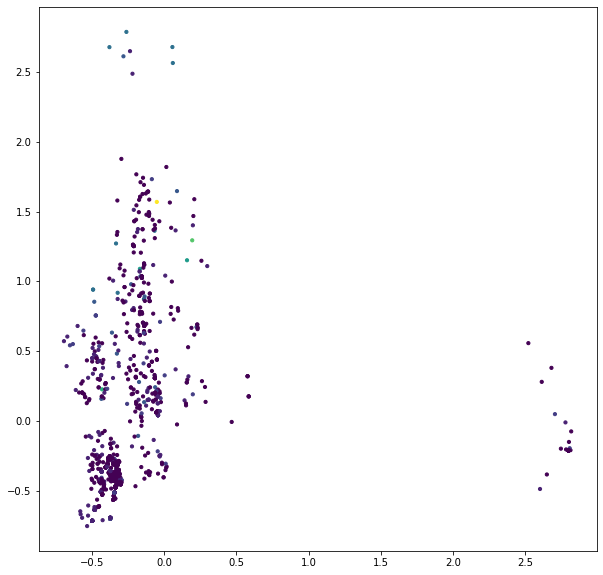

In [130]:
total_blocked = format_df.blocked_chain.apply(lambda x: sum([float(i) for i in x.split(' ')]))

pl.figure(figsize=(10,10))
pl.scatter(pca_model[:,0],pca_model[:,1],s=10,c=total_blocked)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  3.,  2.,  1.,  6.,  4.,  5.,  6.,  1.,  5.,  9.,  7.,
         5.,  9.,  9.,  6., 22., 12., 18., 17., 19., 26., 22., 31., 21.,
        29., 31., 29., 36., 22., 34., 25., 40., 23., 33., 30., 28., 29.,
        26., 32., 31., 24., 16., 15., 28., 18., 18., 20., 13., 13.,  6.,
         7., 10.,  3.,  7., 10., 11.,  5.,  3.,  2.,  2.,  5.,  2.,  1.,
         2.,  3.,  3.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.31646784, 0.32032306, 0.32417829, 0.32803351, 0.33188874,
        0.33574397, 0.33959919, 0.34345442, 0.34730964, 0.35116487,
        0.3550201 , 0.35887532, 0.36273055, 0.36658577, 0.370441  ,
        0.37429623, 0.37815145, 0.38200668, 0.3858619 , 0.38971713,
        0.39357236, 0.39742758, 0.40128281, 0.40513804, 0.40899326,
        0.41284849, 0.41670371, 0.42055894, 0.42441417, 0.42826939,
        0.43212462, 0.4359

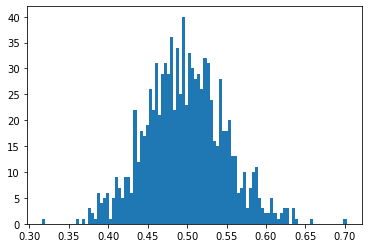

In [321]:
pl.hist(np.random.normal(0.5,scale=0.05,size=1000),bins=100)

In [660]:
grav_df.domain.isin(['canvas.tufts.com']).sum()

0